In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from utils import get_music_time_series, plot_periodogram, read_csv_properly, test_augmented_df

sns.set_palette("viridis")

The DataFrame is a historical record of songs I played since Oct/2020. Every song played in either Spotify, Youtube or SoundCloud is recorded in Last.fm using an API in these players. I do this mainly just because I just really like music and to check out what I heard recently.

In [2]:
music = read_csv_properly("scrobbles_slayeronz.csv")
music

,date_played,artist,album,track
0,2024-06-06 03:07:00,chão de taco,Adiante,Adiante
1,2024-06-06 03:04:00,Locomotiva,Chão de Taco (Locomotiva Sessions),Tempo da Inocência (Locomotiva Sessions)
2,2024-06-06 03:00:00,Locomotiva,Chão de Taco (Locomotiva Sessions),A Gente Nunca Mais Se Vê (Locomotiva Sessions)
3,2024-06-06 02:58:00,chão de taco,difícil,se você quiser
4,2024-06-06 02:56:00,chão de taco,difícil,não sei
...,...,...,...,...
5093,2022-01-30 23:27:00,Reignwolf,Are You Satisfied?,Are You Satisfied?
5094,2022-01-30 23:22:00,LOCK IN: GAUCI,NaN,To Save A Moment
5095,2022-01-30 23:18:00,Mumford & Sons,Sigh No More,Roll Away Your Stone
5096,2022-01-30 23:12:00,Noah Roche,Our Burning Sky,Again


Time series are one of the most common methods of collecting and grouping data. Some data are naturally a time series, because of the context in which is generated / collected. For example, stock market data is measured based on the time. Think of time series as any value measured for a time axis.

I converted the DataFrame to a time series using the `get_music_time_series` function in `utils.py`, if you want to take a look at it.

Either way, let's analyze and explore the dataset, starting with basic line plots and histograms, so that we can have a first impression of how the data behaves and is distributed.

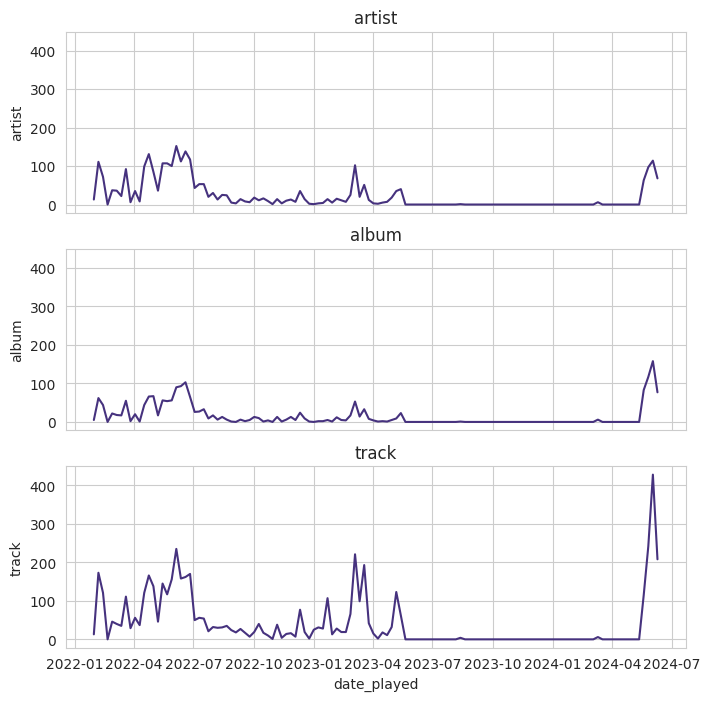

In [3]:
music_series = get_music_time_series(music, "W")

figure, axis = plt.subplots(
	nrows=music_series.shape[1], sharex=True, sharey=True, figsize=(8, 8)
)

for index, column in enumerate(music_series.columns):
	sns.lineplot(data=music_series[column], ax=axis[index])
	axis[index].title.set_text(column)

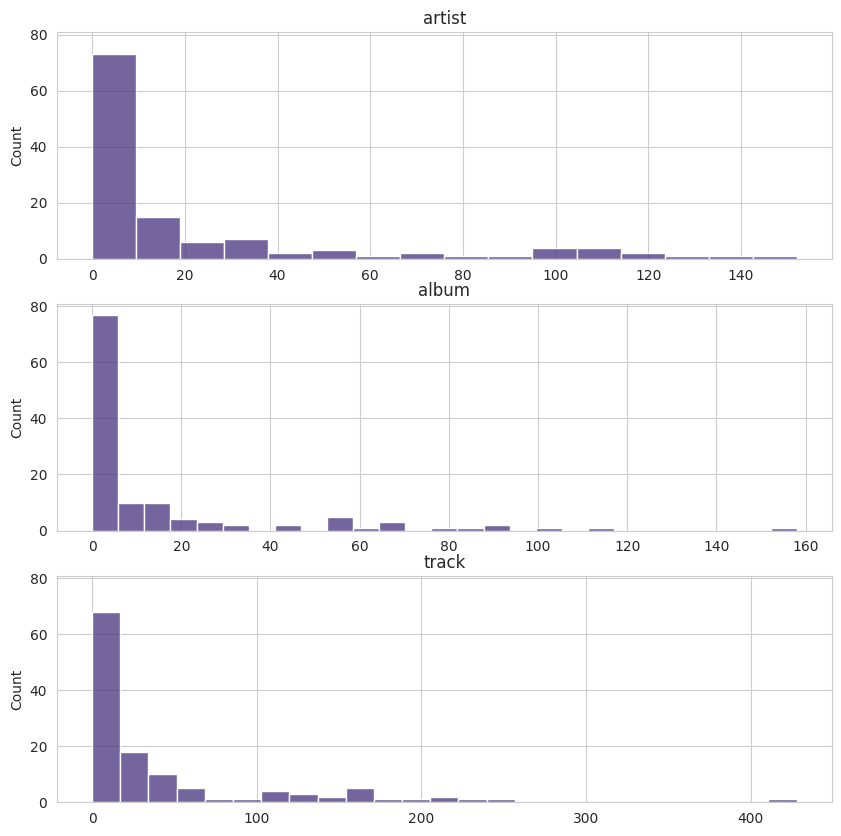

In [4]:
figure, axis = plt.subplots(
	nrows=music_series.shape[1], sharey=True, figsize=(10, 10)
)

for index, column in enumerate(music_series.columns):
	sns.histplot(data=music_series[column], ax=axis[index]).set_xlabel(None)
	axis[index].title.set_text(column)

Just from taking a look to these plots, one can assume:

	- The`track` column has the higher variation. This can be valuable for prediction power. It's also skewed due to outliers.

	- The `track` column is definitely not stationary.
   
	- The `artist` and `album` column values seems very similar to each other.

Let's step up a notch and apply some time series specific methods like lag plots and periodograms to our wanted prediction, the `track` column.

Let's also define some characteristics. **The idea is to predict how many songs will be played four weeks into the future.**


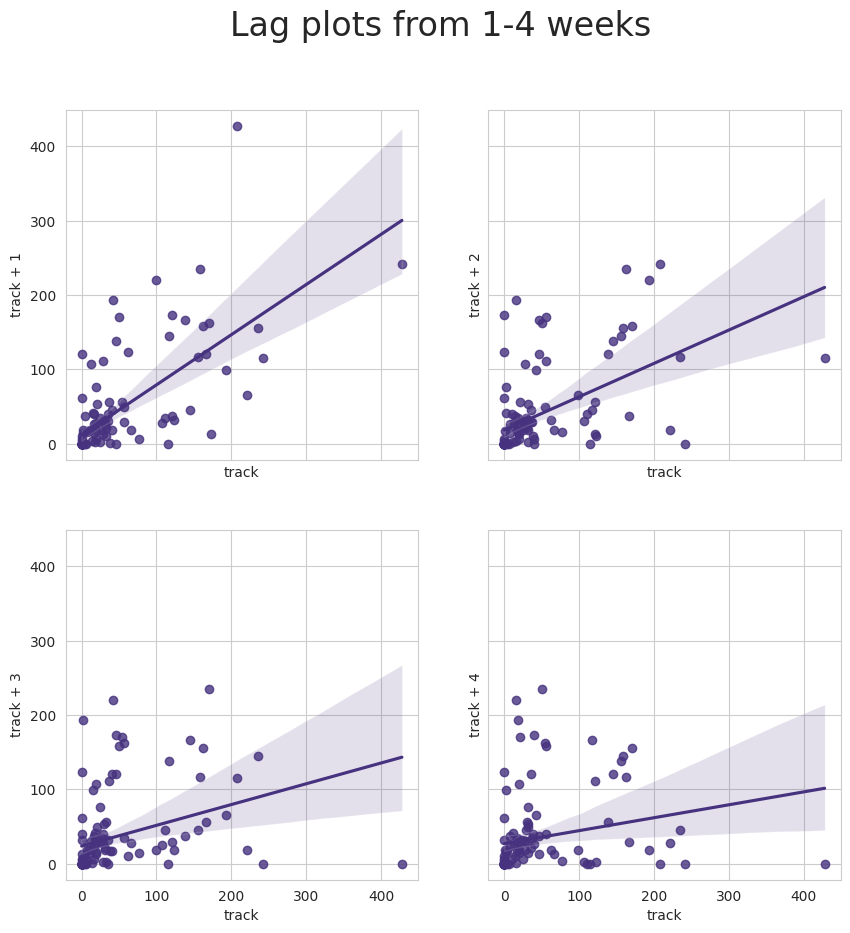

In [5]:
figure, axis = plt.subplots(
	2,2, figsize=(10, 10), sharex=True, sharey=True
)

for lag, ax in enumerate(axis.flatten()):
	sns.regplot(y=music_series["track"].shift(lag + 1), x=music_series["track"], ax=ax)
	ax.set_ylabel(f"track + {lag + 1}")
plt.suptitle("Lag plots from 1-4 weeks", fontsize=24);

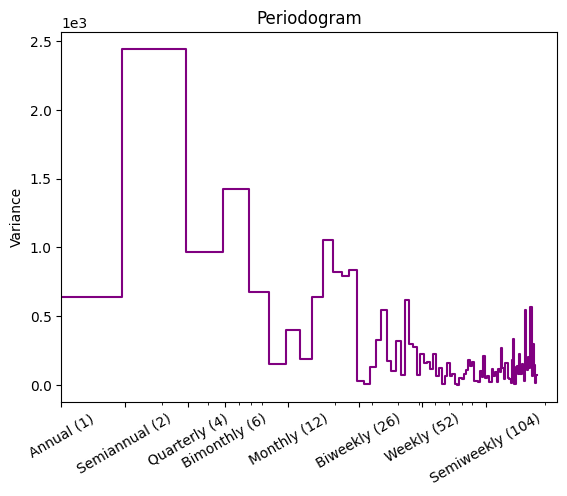

In [6]:
plot_periodogram(music_series["track"]);

Now, we can assume some other information before modelling.

	- Lagging didn't return a valuable way of predicting. Confident predictions are pratically impossible with only lag methods.
  
	- However, applying fourier and retrieving the variation from some time periods shows that there's a lot of variation in annual and monthly periods. We can use this in modelling.

For our final step in analyzing, let's use statsmodels' tsa module.
It shows each component of a time series: trend, seasonality and cyclic/ residuals

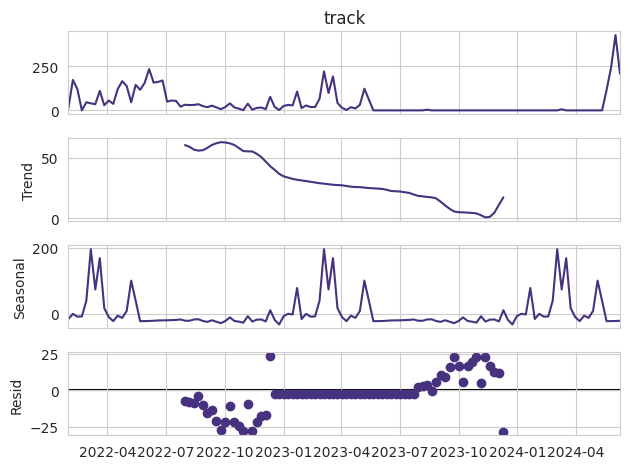

In [6]:
sm.tsa.seasonal_decompose(music_series["track"], model="additive").plot();

I think it's pretty clear that the data has a downward trend. But let's apply an Adfuller test because it's cool.

The Adfuller test is a hypothesis test that assummes Ho as non-stationary data, and H1 as stationary. It applies an autoregressive model, like the lag plots in the EDA. It then tests that the alpha coefficient of the model if equal to 1. Crazy things in the background!!!

In [7]:
test_augmented_df(music_series["track"])

adf :  -2.241526635058523
p-value :  0.19152023395672274


Our p-value is > 0.05. We can't reject the null hypothesis. Therefore, our series is statistically non-stationary for 6 lags (which is the period used in inference + 2 weeks).
Now, we can start modelling!